# Classifier for the MNIST dataset with the VGG16 architecture

Let's import the necessary libraries, the pre-trained model and the MNIST dataset.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [31]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Let's check the shape of the datasets.

In [32]:
print("Training data shape:", x_train.shape) 
print("Test data shape:", x_test.shape) 

# number of images, 28x28 pixels

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


We can see how an example looks like.

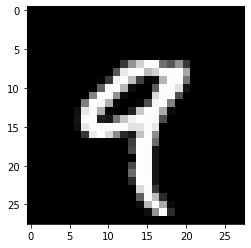

In [33]:
index = 4
example_image = x_train[index]
plt.imshow(example_image, cmap=plt.cm.gray)

## Preprocessing Data

Let's check the labels.

In [34]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [35]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [36]:
print("Training labels shape:", y_train.shape) 
print("Test labels shape:", y_test.shape)

# category numbers for each image

Training labels shape: (60000,)
Test labels shape: (10000,)


In order to feed these labels into the CNN and use them with categorical_crossentropy, we need to perform a conversion into categorical labels.

In [37]:
y_cat_test = to_categorical(y_test) 
y_cat_train = to_categorical(y_train)

# number of classes is inferred 

In [38]:
y_cat_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

We need to resize the data as (32, 32, 3) images for the pre-trained VGG16 model. Here we use OpenCV to resize the images.

In [39]:
import cv2

In [40]:
x_train = [cv2.cvtColor(cv2.resize(im,(32,32)), cv2.COLOR_GRAY2BGR) for im in x_train]
x_train = np.concatenate([arr[np.newaxis] for arr in x_train]).astype('float32')

x_test = [cv2.cvtColor(cv2.resize(im,(32,32)), cv2.COLOR_GRAY2BGR) for im in x_test]
x_test = np.concatenate([arr[np.newaxis] for arr in x_test]).astype('float32')

Each channel is populated by the same original grayscale values.

In [41]:
print("Training data shape:", x_train.shape) 
print("Test data shape:", x_test.shape)

Training data shape: (60000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In order to preprocess *x_train, x_test* I cannot apply the function *preprocess_input* because the latter subtracts the ImageNet mean values [103.939, 116.779, 123.68]. 

Since I duplicated the grayscale values, this would introduce artificial differences between the channels. 

Instead I perform a standard normalization which I verified gives the best performance.

In [42]:
#x_train = preprocess_input(x_train)
#x_test = preprocess_input(x_test)

In [43]:
x_train = x_train/255
x_test = x_test/255

## Build the Model

In [44]:
#use the pre-trained weights from ImageNet and do not include the top layers
model = VGG16(weights = 'imagenet', include_top=False, input_shape = (32, 32, 3)) 

#freeze all layers and train the custom layers only
for layer in model.layers:
    layer.trainable = False

#add custom top layers 
x = model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(10, activation="softmax")(x)

#the final model 
my_model = Model(inputs = model.input, outputs = x)

my_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

my_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

## Train the Model

Let's introduce an early stopping callback.

In [45]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [46]:
my_model.fit(x_train, y_cat_train, batch_size=64, epochs=10, validation_data=(x_test,y_cat_test), callbacks=[early_stop]) 

Epoch 1/10
938/938 [==============================] - 485s 518ms/step - loss: 0.2874 - accuracy: 0.9094 - val_loss: 0.1602 - val_accuracy: 0.9463
Epoch 2/10
938/938 [==============================] - 489s 521ms/step - loss: 0.1307 - accuracy: 0.9586 - val_loss: 0.1041 - val_accuracy: 0.9654
Epoch 3/10
938/938 [==============================] - 489s 522ms/step - loss: 0.1111 - accuracy: 0.9638 - val_loss: 0.1005 - val_accuracy: 0.9671
Epoch 4/10
938/938 [==============================] - 489s 521ms/step - loss: 0.0962 - accuracy: 0.9680 - val_loss: 0.0912 - val_accuracy: 0.9694
Epoch 5/10
938/938 [==============================] - 487s 520ms/step - loss: 0.0866 - accuracy: 0.9709 - val_loss: 0.0902 - val_accuracy: 0.9699
Epoch 6/10
938/938 [==============================] - 485s 517ms/step - loss: 0.0782 - accuracy: 0.9746 - val_loss: 0.1654 - val_accuracy: 0.9427
Epoch 7/10
938/938 [==============================] - 490s 522ms/step - loss: 0.0738 - accuracy: 0.9757 - val_loss: 0.0899 -

## Evaluate the Model

We create a dataframe for the losses and accuracies and then plot them.

In [47]:
loss_acc = pd.DataFrame(my_model.history.history)

(0.0, 9.0)

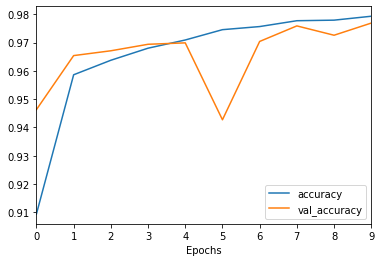

In [49]:
loss_acc[['accuracy','val_accuracy']].plot()
plt.xlabel('Epochs')
plt.xlim(0,9)

(0.0, 9.0)

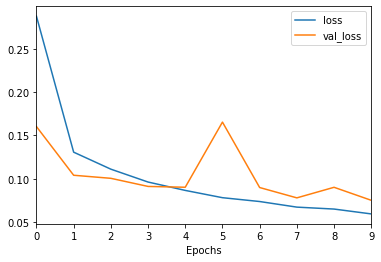

In [50]:
loss_acc[['loss','val_loss']].plot()
plt.xlabel('Epochs')
plt.xlim(0,9)

In [51]:
print(my_model.metrics_names)
print(my_model.evaluate(x_test,y_cat_test,verbose=0)) 

['loss', 'accuracy']
[0.07517494261264801, 0.9768999814987183]


Let's explore more metrics from *sklearn.metrics*.

In [52]:
from sklearn.metrics import classification_report,confusion_matrix

In [53]:
y_prob = my_model.predict(x_test) 
predictions = y_prob.argmax(axis=-1)

In [54]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.96      0.99      0.97       982
           5       0.98      0.96      0.97       892
           6       0.99      0.97      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



We see that our model performs pretty well across all the categories. 

We can also have a more visual understanding of the performances of the model by plotting the heatmap of the confusion matrix.

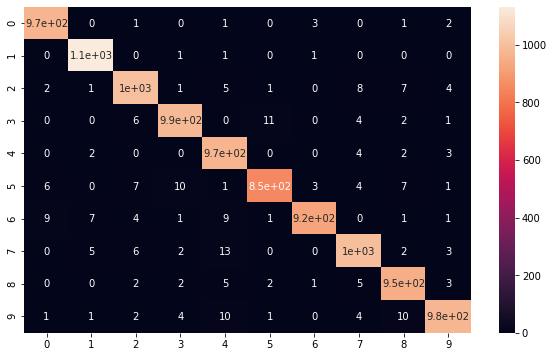

In [55]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)

## Predict a given image

To see how one can predict a given image, we use a random example from *x_test*.

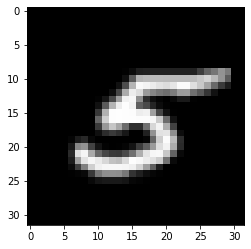

In [56]:
import random
example_index = random.randint(0,9999)
my_number = x_test[example_index]
plt.imshow(my_number)

In [57]:
y_prob = my_model.predict(x_test[example_index].reshape(1,32,32,3))
y_prob.argmax(axis=-1)

array([5])

Our model correctly classifies the image!